In [1]:
from IPython import display as disp
import torch
import torchaudio
from scipy.signal import wiener, convolve
from scipy.special import sinc
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib
import soundfile
import torchvision
from torchvision import transforms, utils

In [2]:
torch.cuda.is_available()

True

In [3]:
!wget https://spandh.dcs.shef.ac.uk/avlombard/data/lombardgrid_audio.zip

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [4]:
!unzip -q lombardgrid_audio.zip

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [5]:
import os
wav, sr = torchaudio.load("../audio/" + os.listdir("../audio")[2222], format="wav")
disp.display(disp.Audio(wav.numpy(), rate=sr))


In [166]:
from torch.utils.data import Dataset, DataLoader

class GRIDDataset(Dataset):
    """
    GRID dataset

    https://spandh.dcs.shef.ac.uk/avlombard
    """

    def __init__(self, root_dir, format='wav', transform=None):
        """
        Arguments:
            root_dir (string): A path, root directory.
        """
        self.root_dir = root_dir
        self.files = os.listdir(root_dir)
        self.format = format
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        speaker = float(self.files[idx].split("_")[0][1:])
        signal, sr = torchaudio.load(
            self.root_dir + "/" + self.files[idx],
            format=self.format
        )

        sample = {'speaker' : speaker, 'signal': signal, 'sr' : sr}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [167]:
def collate_grid(batch):
  # L = max([x['signal'].shape[1] for x in batch])
  L = 40000
  T = 100
  batch_ = []
  for x in batch:
    if x['spectrogram'].shape[2] >= T:
      batch_.append(x)
  batch = batch_
  for x in batch:
    if x['signal'].shape[1] < L:
      x['signal'] = torch.cat((x['signal'], torch.zeros(1, L - x['signal'].shape[1])), dim=1)
    else:
      x['signal'] = x['signal'][:, :L]
    # x['spectrogram'] = torch.flatten(x['spectrogram'][:, :, :T], start_dim=1)
    x['spectrogram'] = x['spectrogram'][:, :, :T]
  return {
      'signal': torch.stack([x['signal'] for x in batch]),
      'spectrogram': torch.stack([x['spectrogram'] for x in batch]),
      'speaker': torch.tensor([x['speaker'] for x in batch]),
      'sr': torch.tensor([x['sr'] for x in batch])
}

In [231]:
def melForward(f):
    return 2595*np.log10(1 + f/700) #wikipedia suggestion
def melInverse(m):
    return (10**(m/2595)-1)*700

class Spectrogrammify(object):
    """Convert waveform to spectrogram."""

    def __call__(self, sample):
        speaker, signal, sr = sample['speaker'], sample['signal'], sample['sr']

        nFFT = 1024
        windowSize = nFFT
        hopSize = 256
        window = torch.hann_window(windowSize)

        spectrum1 = torch.stft(
            signal,
            n_fft=nFFT,
            hop_length=hopSize,
            win_length=windowSize,
            window=window,
            center=False,
            onesided=True,
            return_complex=True,
        )

        spectrogram = melForward(spectrum1.abs().pow(2) + 1e-8)

        return {'speaker' : speaker, 'signal' : signal, 'sr' : sr, 'spectrogram' : spectrogram}
    
class NormalizeSpectrogram(object):
    """Convert waveform to spectrogram."""

    def __call__(self, sample):
        speaker, signal, sr, spectrogram = sample['speaker'], sample['signal'], sample['sr'], sample['spectrogram']

        normalize = transforms.Normalize(0, 1)

        return {'speaker' : speaker, 'signal' : signal, 'sr' : sr, 'spectrogram' : spectrogram} # normalize(spectrogram)}

In [232]:
ROOT_DIR = '../audio/'
dataset = GRIDDataset(
  root_dir=ROOT_DIR, 
  transform=transforms.Compose([Spectrogrammify(), NormalizeSpectrogram()]))
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, # num_workers=2,
                        collate_fn=collate_grid)

print(dataset[1])

# if __name__ == '__main__':
for i_batch, sample in enumerate(dataloader):
    print(i_batch, sample['signal'].shape, sample['spectrogram'].shape)

    # observe 4th batch and stop.
    if i_batch == 5:
      break

{'speaker': 10.0, 'signal': tensor([[0.0007, 0.0008, 0.0008,  ..., 0.0005, 0.0007, 0.0008]]), 'sr': 16000, 'spectrogram': tensor([[[0.2194, 0.0160, 0.0097,  ..., 0.2773, 0.1397, 0.0056],
         [0.1691, 0.0339, 0.0019,  ..., 0.1573, 0.1049, 0.0095],
         [0.0470, 0.0525, 0.0132,  ..., 0.0179, 0.0154, 0.0171],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])}
0 torch.Size([4, 1, 40000]) torch.Size([4, 1, 513, 100])
1 torch.Size([4, 1, 40000]) torch.Size([4, 1, 513, 100])
2 torch.Size([4, 1, 40000]) torch.Size([4, 1, 513, 100])
3 torch.Size([4, 1, 40000]) torch.Size([4, 1, 513, 100])
4 torch.Size([4, 1, 40000]) torch.Size([4, 1, 513, 100])
5 torch.Size([4, 1, 40000]) torch.Size([4, 1, 513, 100])


In [234]:
dataset[1]['spectrogram']

tensor([[[0.2194, 0.0160, 0.0097,  ..., 0.2773, 0.1397, 0.0056],
         [0.1691, 0.0339, 0.0019,  ..., 0.1573, 0.1049, 0.0095],
         [0.0470, 0.0525, 0.0132,  ..., 0.0179, 0.0154, 0.0171],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [253]:
from torch import nn
from torch.nn import functional as F

speakers = 55

class FFN(nn.Module):
    def __init__(self, n_layers, input_size, output_size, hidden_size):
        super(FFN, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding="same"),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding="same"),
            nn.MaxPool2d(4, 4),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3,3), padding="same"),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(1536, 256),
            nn.Linear(256, output_size),
            #nn.Softmax(dim=1)            
        )

    def forward(self, x):
        out = self.seq(x)
        return out # F.softmax(out, dim=-1)

In [288]:
import wandb

def train_epoch(model, dataloader_train, optimizer, device):
    losses = []
    accuracies = []
    for sample in dataloader_train:
        x_batch = sample['spectrogram'].to(device)
        y_batch = sample['speaker'].to(device)

        # print("X: " , x_batch.shape)
        # print("Y: ", y_batch.shape, y_batch)

        output = model(x_batch)

        # print("<X, W> = ", output.shape)
        # print(output)

        pred = torch.argmax(output[:, :], 1)

        # print("<X, W>.argmax = ", pred.shape, pred)

        acc = torch.mean((pred == y_batch - 1).float())

        # y_batch = F.one_hot(y_batch.long(), speakers)
        # loss = F.nll_loss(output[:, :], (y_batch - 1).long())
        loss = nn.CrossEntropyLoss(reduction='sum')(output[:, :], (y_batch - 1).long())
        # print(acc, loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss)
        accuracies.append(acc)

    losses = torch.Tensor(losses)
    accuracies = torch.Tensor(accuracies)

    return (losses.sum() / losses.shape[0]).item(), (accuracies.sum() / accuracies.shape[0]).item()

def train(model, dataloader_train, dataloader_test, optimizer, n_epochs, device):
    wandb.init()
    model.train()
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        loss, acc = train_epoch(model, dataloader_train, optimizer, device)
        print(f"Train loss: {loss}, acc: {acc}")
        wandb.log({"train_loss" : loss, "tain_acc" : acc})

        val_loss, val_acc = test(model, dataloader_test, device)
        print(f"Val loss: {val_loss}, acc: {val_acc}")
        wandb.log({"val_loss" : val_loss, "val_acc" : val_acc})
        
    wandb.finish()


def test(model, dataloader_test, device):
    model.eval()
    losses = []
    accuracies = []
    for sample in dataloader_test:
        x_batch = sample['spectrogram'].to(device)
        y_batch = sample['speaker'].to(device)
        # y_batch = F.one_hot(y_batch.long(), speakers)

        with torch.no_grad():
            output = model(x_batch)
            loss = nn.CrossEntropyLoss(reduction='sum')(output[:, :], (y_batch - 1).long())

            pred = torch.argmax(output[:, :], 1)
            acc = torch.mean((pred == y_batch - 1).float())

            losses.append(loss)
            accuracies.append(acc)
        
    losses = torch.Tensor(losses)
    accuracies = torch.Tensor(accuracies)

    return (losses.sum() / losses.shape[0]).item(), (accuracies.sum() / accuracies.shape[0]).item()


In [289]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [290]:
dataset = GRIDDataset(root_dir=ROOT_DIR, transform=transforms.Compose([Spectrogrammify()]))
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, # num_workers=2,
                        collate_fn=collate_grid)

In [291]:
SZ = 513 * 100
SZ

51300

In [293]:
model = FFN(n_layers=10, input_size=SZ, output_size=speakers, hidden_size=256)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, dataloader, dataloader, optimizer, n_epochs=10, device=device)

tain_acc,▁
train_loss,▁
tain_acc,0.35324
train_loss,10.47127


Epoch 0 of 10
Train loss: 11.685212135314941, acc: 0.2795499563217163
Val loss: 6.857816696166992, acc: 0.5711548328399658
Epoch 1 of 10
Train loss: 4.5736541748046875, acc: 0.6993076205253601
Val loss: 3.0671234130859375, acc: 0.8382171988487244
Epoch 2 of 10
Train loss: 1.6442445516586304, acc: 0.8889712691307068
Val loss: 1.0662575960159302, acc: 0.9271142482757568
Epoch 3 of 10
Train loss: 1.0037363767623901, acc: 0.9355835318565369
Val loss: 0.470403254032135, acc: 0.9695228338241577
Epoch 4 of 10
Train loss: 0.6268724799156189, acc: 0.95839524269104
Val loss: 0.31810280680656433, acc: 0.9796612858772278
Epoch 5 of 10
Train loss: 0.7142890095710754, acc: 0.9557369351387024
Val loss: 0.23776549100875854, acc: 0.9854105114936829
Epoch 6 of 10
Train loss: 0.3901827335357666, acc: 0.9758283495903015
Val loss: 0.13712768256664276, acc: 0.9926433563232422
Epoch 7 of 10
Train loss: 0.3271144926548004, acc: 0.9786103367805481
Val loss: 0.7288287878036499, acc: 0.9546241760253906
Epoch 8 o

tain_acc,▁▅▇███████
train_loss,█▄▂▁▁▁▁▁▁▁
val_acc,▁▅▇████▇██
val_loss,█▄▂▁▁▁▁▂▁▁
tain_acc,0.97756
train_loss,0.34878
val_acc,0.99499
val_loss,0.10334


In [299]:
sample = next(iter(dataloader))
sample

{'signal': tensor([[[ 4.3029e-04,  4.2468e-04,  4.4227e-04,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 4.1795e-04,  4.0573e-04,  4.3124e-04,  ...,  6.1929e-05,
            2.6107e-05, -3.9279e-05]],
 
         [[ 1.7786e-04,  1.7470e-04,  1.5652e-04,  ...,  3.6299e-04,
           -2.6345e-05,  1.3542e-04]]]),
 'spectrogram': tensor([[[[8.5910e-01, 6.4362e+00, 8.0519e+00,  ..., 1.1132e+00,
            1.2357e+00, 1.3716e-01],
           [8.5010e-01, 2.6667e+00, 3.8610e+00,  ..., 3.8404e-01,
            5.6587e-01, 3.4334e-01],
           [8.5980e-02, 9.1622e-02, 2.0433e-01,  ..., 2.3376e-02,
            2.9422e-02, 3.6945e-02],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]]],
 
 
     

In [304]:
output = model(sample['spectrogram'].to(device))
pred = torch.argmax(output[:, :], 1)
pred + 1

tensor([ 7, 45, 29], device='cuda:0')

In [308]:
sample['signal'].shape

torch.Size([3, 1, 40000])

In [319]:
# wav, sr = torchaudio.load("../audio/" + os.listdir("../audio")[2000], format="wav")
idx = 2
disp.display(disp.Audio(sample['signal'][idx, 0, :].numpy(), rate=int(sample['sr'][idx])))

In [292]:
import gc
torch.cuda.empty_cache()
gc.collect()

4521

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [138]:
import os
wav, sr = torchaudio.load("../audio/" + os.listdir("../audio")[100], format="wav")
disp.display(disp.Audio(wav.numpy(), rate=sr))

In [139]:
nFFT = 1024
windowSize = nFFT
hopSize = 256
window = torch.hann_window(windowSize)

In [140]:
def melForward(f):
    return 2595*np.log10(1 + f/700) #wikipedia suggestion
def melInverse(m):
    return (10**(m/2595)-1)*700

torch.Size([1, 513, 50])


C:\Users\maxro\AppData\Local\Temp\ipykernel_5112\3846563539.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


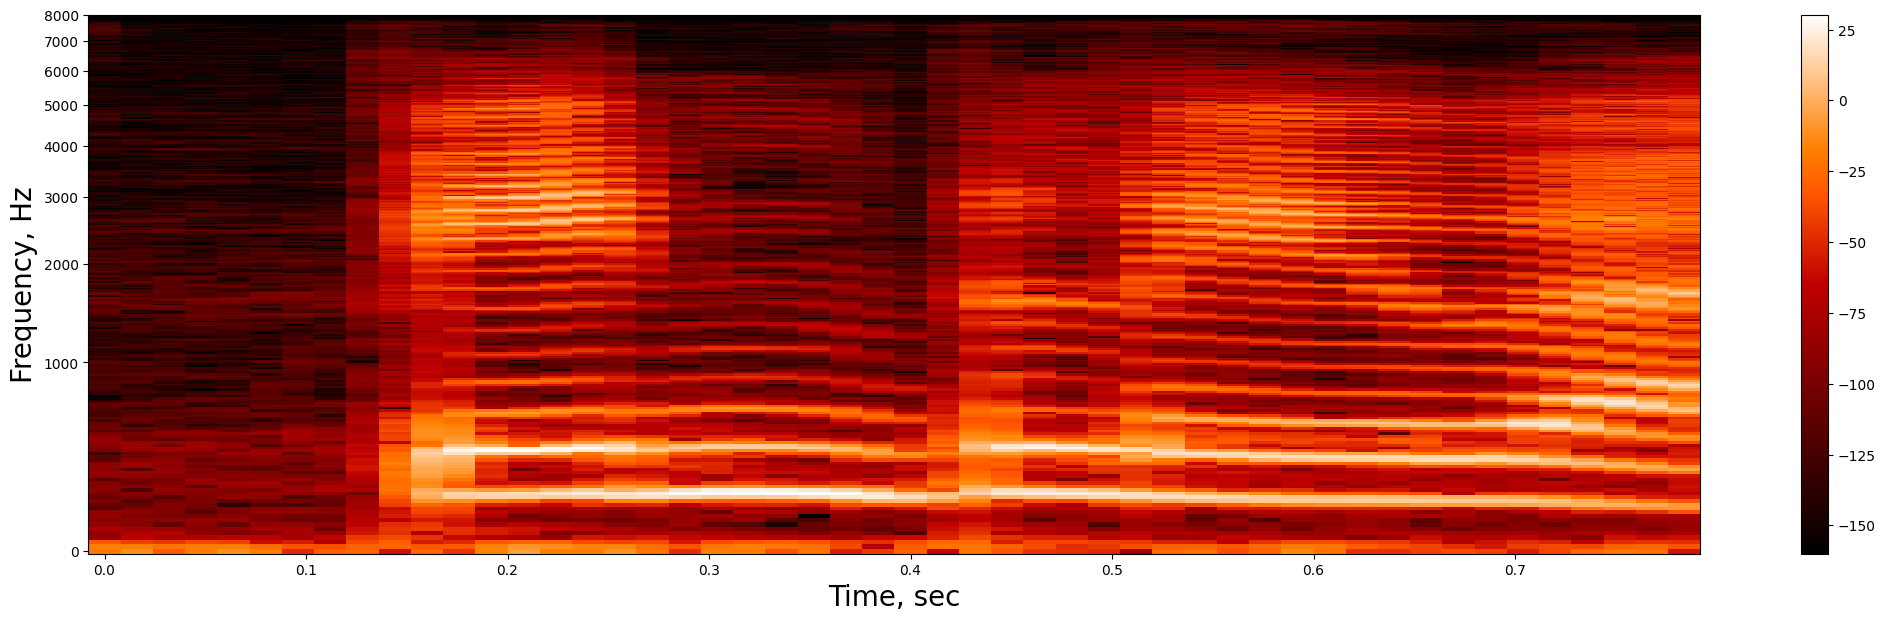

In [230]:
spectrum1 = torch.stft(
    wav,
    n_fft=nFFT,
    hop_length=hopSize,
    win_length=windowSize,
    window=window,
    center=False,
    onesided=True,
    return_complex=True,
)

# spectrogram = spectrum1.norm(dim=-1).pow(2)

# spectrum1[:, :67] = 0
# spectrum1[:, :100] = 0

spectrogram = spectrum1.abs().pow(2)

spectrogram = spectrogram[:, :, :50]
print(spectrogram.shape)

f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,spectrogram.shape[2]*hopSize, hopSize)/sr
fGrid = np.arange(0,nFFT/2+0.00001)/(nFFT)*sr
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(spectrogram.squeeze()+1e-8),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

In [220]:
spectrogram.shape

torch.Size([1, 513, 100])

In [113]:
torch.flatten(spectrogram, start_dim=1).shape

torch.Size([1, 68742])

In [ ]:
wav_revived = torch.istft(spectrum1,
                          n_fft=nFFT,
                          hop_length=hopSize,
                          win_length=windowSize,
                          window=window)
wav_revived.shape

torch.Size([1, 43264])

In [ ]:
disp.display(disp.Audio(wav_revived.numpy(), rate=sr))

In [ ]:
torch.cat((wav_revived, torch.zeros(wav.shape[1] - wav_revived.shape[1])[None, :]), dim=1).shape

torch.Size([1, 44320])

In [ ]:
torch.norm(torch.cat((wav_revived, torch.zeros(wav.shape[1] - wav_revived.shape[1])[None, :]), dim=1)) / wav.shape[1]

tensor(6.7353e-05)